In [64]:
# importar las librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, roc_auc_score

In [65]:
# cargar los datos del conjunto de entrenamiento y el conjunto de validación
df_train_original = pd.read_csv("data/dataset_marketing_train.csv")
df_val_original = pd.read_csv("data/dataset_marketing_test.csv")

In [66]:
# Convierte las variables categóricas en variables numéricas con una codificación one-hot
df_train_val = pd.concat([df_train_original, df_val_original])
df_train_val = pd.get_dummies(df_train_val, columns=["empleo", "estado", "educacion", "impago", "hipoteca", "prestamo", "tipo_contacto", "mes", "dia_semana", "resultado_anterior"])

# Elimina las filas con valores nulos
df_train_val = df_train_val.dropna()

# Separa el conjunto de datos de entrenamiento y el conjunto de datos de validación
df_train = df_train_val.iloc[:len(df_train)]
df_val = df_train_val.iloc[len(df_train):]


In [67]:
# seleccionar las características y la variable objetivo
X_train = df_train.drop("target", axis=1)
y_train = df_train["target"]
X_val = df_val.drop("target", axis=1)
y_val = df_val["target"]


In [68]:
# crear y entrenar el modelo de aprendizaje automático
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [69]:
# evaluar el modelo en el conjunto de validación
y_pred = model.predict(X_val)
accuracy = (y_pred == y_val).mean()
print(f"Precisión en el conjunto de validación: {accuracy:.2f}")

Precisión en el conjunto de validación: 0.94


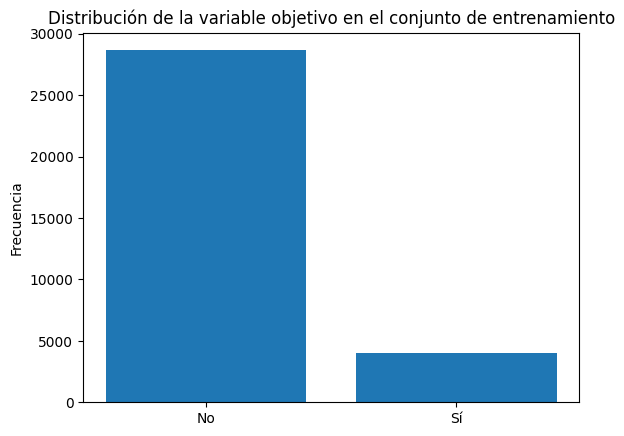

In [70]:
# representación gráficamente la distribución de la variable objetivo en el conjunto de entrenamiento
counts = df_train["target"].value_counts()
plt.bar(counts.index, counts)
plt.xticks(counts.index, ["No", "Sí"])
plt.ylabel("Frecuencia")
plt.title("Distribución de la variable objetivo en el conjunto de entrenamiento")
plt.show()

In [71]:
# Selecciona la variable objetivo
y_train = df_train["target"]
y_val = df_val["target"]

# Cuenta el número de conversiones en cada conjunto de datos
n_conversions_train = (y_train == "yes").sum()
n_conversions_val = (y_val == "yes").sum()

# Cuenta el número total de contactos en cada conjunto de datos
n_contacts_train = len(y_train)
n_contacts_val = len(y_val)

# Calcula la tasa de conversión de cada conjunto de datos
conversion_rate_train = n_conversions_train / n_contacts_train
conversion_rate_val = n_conversions_val / n_contacts_val

# Imprime los resultados
print(f"Tasa de conversión en el conjunto de entrenamiento: {conversion_rate_train:.2f}")
print(f"Tasa de conversión en el conjunto de validación: {conversion_rate_val:.2f}")


Tasa de conversión en el conjunto de entrenamiento: 0.12
Tasa de conversión en el conjunto de validación: 0.08


In [72]:
# Agrupamos los datos por las variables mes y dia_semana
df_grouped_month = df_train_original.groupby(["mes"])
df_grouped_week = df_train_original.groupby(["dia_semana"])

# Calculamos el ratio de conversión por mes
conversion_rates_month = df_grouped_month["target"].apply(lambda x: (x == "yes").sum() / len(x))
conversion_rates_week = df_grouped_week["target"].apply(lambda x: (x == "yes").sum() / len(x))

# Imprime los resultados
print(conversion_rates_month)
print(conversion_rates_week)

mes
apr    0.204787
aug    0.089992
dec    0.489011
jul    0.068920
jun    0.088819
mar    0.505495
may    0.107559
nov    0.101439
oct    0.438719
sep    0.449123
Name: target, dtype: float64
dia_semana
fri    0.118641
mon    0.105444
thu    0.128184
tue    0.132118
wed    0.128735
Name: target, dtype: float64


In [73]:
# calcular la matriz de confusión en el conjunto de validación
confusion_matrix = confusion_matrix(y_val, y_pred)
print(f"Matriz de confusión en el conjunto de validación:\n{confusion_matrix}")

Matriz de confusión en el conjunto de validación:
[[7812   81]
 [ 417  226]]


In [74]:
# transformar las variables estado y resultado_anterior utilizando one-hot encoding (ya estaban transformadas en el modelo)
df_train_enc = pd.get_dummies(df_train_original, columns=["estado", "resultado_anterior"])
df_val_enc = pd.get_dummies(df_val_original, columns=["estado", "resultado_anterior"])
print(df_train_enc)
print(df_val_enc)

       edad       empleo            educacion   impago hipoteca prestamo  \
0        26   management    university.degree       no       no       no   
1        42   technician  professional.course  unknown       no       no   
2        30       admin.    university.degree       no       no       no   
3        55   technician             basic.9y       no       no       no   
4        41  blue-collar             basic.4y       no      yes       no   
...     ...          ...                  ...      ...      ...      ...   
32647    73      retired  professional.course       no      yes       no   
32648    46  blue-collar  professional.course       no       no       no   
32649    56      retired    university.degree       no      yes       no   
32650    44   technician  professional.course       no       no       no   
32651    74      retired  professional.course       no      yes       no   

      tipo_contacto  mes dia_semana  contactos_actual  ...  euribor_3m  \
0         tel

In [75]:
# calcular el área bajo la curva (AUC) en el conjunto de validación
X_val = df_val.drop("target", axis=1)
y_val = df_val["target"]

# Predice las probabilidades de clase para el conjunto de validación
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Calcula el AUC en el conjunto de validación
auc = roc_auc_score(y_val, y_pred_proba)

# Imprime el resultado
print(f"Área bajo la curva (AUC) en el conjunto de validación: {auc:.2f}")

Área bajo la curva (AUC) en el conjunto de validación: 0.80


In [76]:
# Calcular las probabilidades predichas de venta para cada cliente en el conjunto de validación
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Establecer el balance máximo inicial y el umbral
max_balance = -float("inf")
best_limit = 0

# Iterar sobre un rango de umbrales
for limit in range(0, 100):
    # Convertir las probabilidades en una predicción binaria utilizando el umbral
    y_pred = (y_pred_proba >= limit / 100).astype(int)
    
    # Calcular el número de clientes contactados y el número de clientes que contrataron
    n_contacts = y_pred.sum()
    n_conversions = (y_pred == y_val).sum()
    
    # Calcular el balance para este umbral
    balance = 100 * n_conversions - 1 * n_contacts
    
    # Actualizar el balance máximo y el umbral si es necesario
    if balance > max_balance:
        max_balance = balance
        best_limit = threshold

# Imprimir el mejor umbral y el balance máximo
print(f"Mejor umbral: {best_limit / 100}")
print(f"Balance máximo: {max_balance}")


Mejor umbral: 0.99
Balance máximo: 0
